"IMPLEMENTASI MODEL RESNET PADA CITRA PENYAKIT DAUN DENGAN METODE JARINGAN SYARAF KONVOLUSIONAL (CNN)" oleh Muhammad Jafar Shodiq (21120116130052)

# Mengimport Library dan Mendefinisikan Variabel

In [0]:
#mengimport direktori dari google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#menghitung total waktu jalannya program
import time
total_time = time.time()

#mengabaikan peringatan
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#membuat data latih dan data uji
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import os
import cv2
import numpy as np
import random as rn
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#membangun model
from tensorflow.python.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.python.keras import optimizers

#visualisasi dan pengujian
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix

In [0]:
Apple___Apple_scab_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Apple___Apple_scab'
Apple___Black_rot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Apple___Black_rot'
Grape___Black_rot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Black_rot'
Grape___Esca_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Esca_(Black_Measles)'
Grape___Leaf_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
Potato___Early_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Potato___Early_blight'
Potato___Late_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Potato___Late_blight'
Tomato___Bacterial_spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Bacterial_spot'
Tomato___Septoria_leaf_spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Septoria_leaf_spot'
Tomato___Target_Spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Target_Spot'

X = []
Z = []

NUM_CLASSES = 10
CHANNELS = 3
IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_STATE = 42
NUM_EPOCHS = 20

RESNET_POOLING = 'avg'
RESNET_WEIGHTS = 'imagenet'
DENSE_LAYER_ACTIVATION = 'relu'
OUTPUT_DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

#yang akan diubah-ubah
TEST_SIZE = 0.2
LEARNING_RATE = 0.0001

# Membuat Data Latih dan Data Uji

In [0]:
def assign_label(img, plantdisease_type):
    return plantdisease_type
    
def make_train_data(plantdisease_type, DIR):
    for img in tqdm(os.listdir(DIR)): #tqdm untuk progress bar
        label = assign_label(img, plantdisease_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR) #membaca file gambar yang ada di masing-masing path
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #mengubah ukuran gambar menjadi 224x224
        
        X.append(np.array(img)) #menambahkan dan mengubah gambar menjadi array
        Z.append(str(label)) #menambahkan kelas/kategori

In [0]:
#menghitung waktu
make_data_time = time.time()
#memproses data yang akan digunakan
make_train_data('Keropeng_Apel', Apple___Apple_scab_DIR)
print(len(X))
make_train_data('Busuk_Hitam_Apel', Apple___Black_rot_DIR)
print(len(X))
make_train_data('Busuk_Hitam_Anggur', Grape___Black_rot_DIR)
print(len(X))
make_train_data('Esca_Anggur', Grape___Esca_DIR)
print(len(X))
make_train_data('Hawar_Daun_Anggur', Grape___Leaf_blight_DIR)
print(len(X))
make_train_data('Bercak_Kering_Kentang', Potato___Early_blight_DIR)
print(len(X))
make_train_data('Hawar_Daun_Kentang', Potato___Late_blight_DIR)
print(len(X))
make_train_data('Bercak_Bakteri_Tomat', Tomato___Bacterial_spot_DIR)
print(len(X))
make_train_data('Bercak_Septoria_Tomat', Tomato___Septoria_leaf_spot_DIR)
print(len(X))
make_train_data('Bercak_Coklat_Tomat', Tomato___Target_Spot_DIR)
print(len(X))
make_data_time_spent = time.time()-make_data_time

  4%|▍         | 22/500 [00:00<00:02, 217.85it/s]

510


  4%|▍         | 22/510 [00:00<00:02, 210.77it/s]

1010


  5%|▍         | 24/500 [00:00<00:01, 239.27it/s]

1520


  5%|▍         | 23/500 [00:00<00:02, 222.82it/s]

2020


  4%|▍         | 22/500 [00:00<00:02, 213.96it/s]

2520


  5%|▍         | 23/500 [00:00<00:02, 229.37it/s]

3020


  5%|▍         | 24/500 [00:00<00:01, 238.81it/s]

3520


  5%|▍         | 24/500 [00:00<00:02, 234.88it/s]

4020


  5%|▌         | 25/500 [00:00<00:01, 249.69it/s]

4520


100%|██████████| 500/500 [00:02<00:00, 236.30it/s]

5020


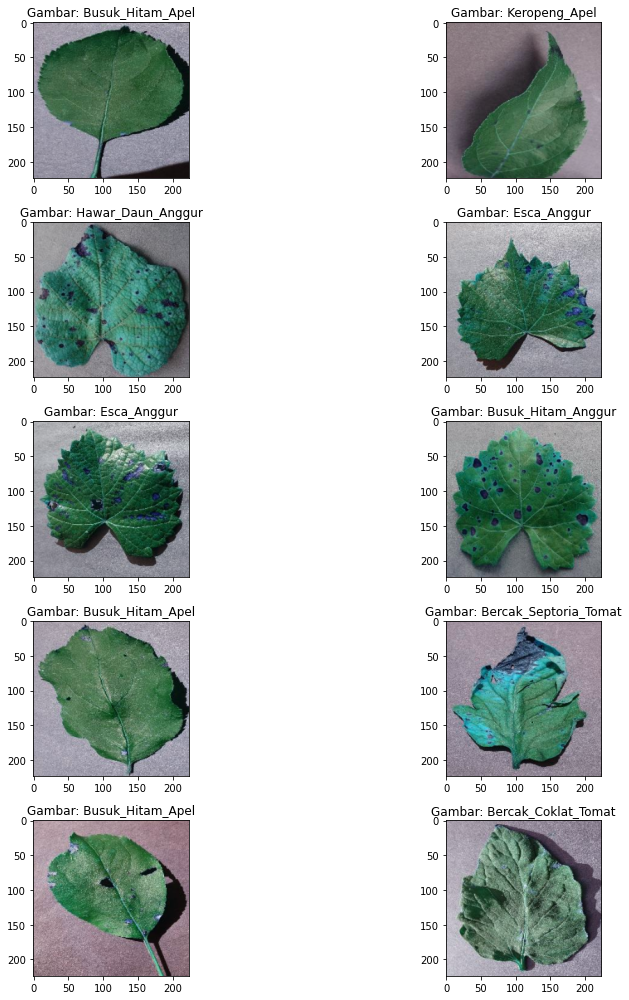

In [0]:
#menampilkan sampel secara acak
fig,ax = plt.subplots(5, 2)
fig.set_size_inches(14, 14)
for i in range(5):
    for j in range (2):
        l = rn.randint(0, len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Gambar: '+Z[l])     
plt.tight_layout()

In [0]:
#mengubah kelas/kategori menjadi angka 0-9
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, NUM_CLASSES)
#normalisasi nilai piksel dengan membagi semua nilai dengan 255
X = np.array(X)
X = X/255

In [0]:
#membagi data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4016, 224, 224, 3)
(4016, 10)
(1004, 224, 224, 3)
(1004, 10)


In [0]:
#menambahkan random seed
np.random.seed(RANDOM_STATE)
rn.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Membuat Model

In [0]:
#mengunduh model resnet
resnet_model = ResNet50(include_top=False, pooling=RESNET_POOLING, weights=RESNET_WEIGHTS, input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS))

In [0]:
#membangun model
model=Sequential()
model.add(resnet_model)
model.add(BatchNormalization())
model.add(Dense(256, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(128, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(64, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation = OUTPUT_DENSE_LAYER_ACTIVATION))
#ResNet tidak perlu dilatih lagi karena sudah dilatih (pre-trained)
model.layers[0].trainable=False

In [0]:
#compile model
ADAM = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
model.compile(optimizer = ADAM, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [0]:
#melihat lapisan, bentuk lapisan, dan jumlah parameter
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

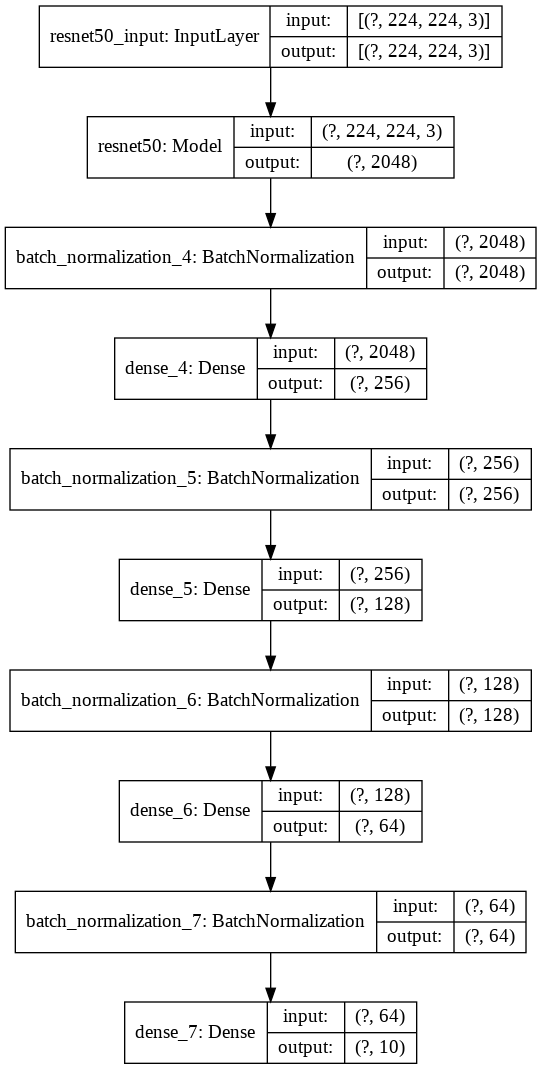

In [0]:
#menampilkan arsitektur model
keras.utils.plot_model(model, "model_architecture.png", show_shapes=True)

In [0]:
#menghitung waktu
train_time = time.time()
#melatih data
fit_history = model.fit(x_train, y_train,
                        epochs = NUM_EPOCHS,
                        batch_size = BATCH_SIZE,
                        validation_data = (x_test, y_test))
train_time_spent = time.time()-train_time

Epoch 1/20
126/126 [==============================] - 361s 3s/step - loss: 1.9501 - accuracy: 0.3536 - val_loss: 2.4104 - val_accuracy: 0.1514
Epoch 2/20
126/126 [==============================] - 360s 3s/step - loss: 1.2537 - accuracy: 0.5971 - val_loss: 2.4350 - val_accuracy: 0.1325
Epoch 3/20
126/126 [==============================] - 361s 3s/step - loss: 0.9907 - accuracy: 0.6897 - val_loss: 1.8105 - val_accuracy: 0.3665
Epoch 4/20
126/126 [==============================] - 362s 3s/step - loss: 0.8344 - accuracy: 0.7323 - val_loss: 1.2161 - val_accuracy: 0.6604
Epoch 5/20
126/126 [==============================] - 362s 3s/step - loss: 0.7224 - accuracy: 0.7811 - val_loss: 0.8960 - val_accuracy: 0.7261
Epoch 6/20
126/126 [==============================] - 362s 3s/step - loss: 0.6572 - accuracy: 0.8045 - val_loss: 0.7647 - val_accuracy: 0.7420
Epoch 7/20
126/126 [==============================] - 364s 3s/step - loss: 0.5797 - accuracy: 0.8250 - val_loss: 0.7097 - val_accuracy: 0.7659

In [0]:
#mengevaluasi hasil latih
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Akurasi Data Uji:', test_acc)

32/32 - 71s - loss: 0.5215 - accuracy: 0.8157
Akurasi Data Uji: 0.8157370686531067


# Memvisualisasikan dan Menguji Model

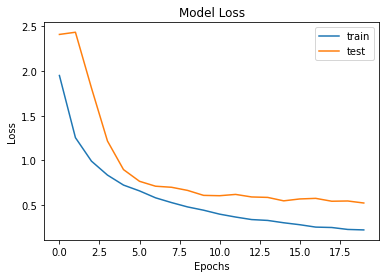

In [0]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

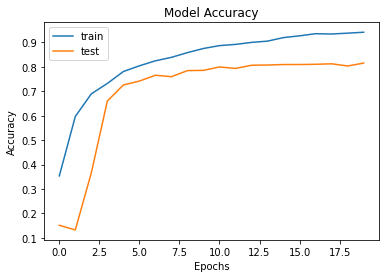

In [0]:
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

                           precision    recall  f1-score   support

        (0) Keropeng_Apel       0.82      0.92      0.86       106
     (1) Busuk_Hitam_Apel       0.86      0.89      0.88       103
   (2) Busuk_Hitam_Anggur       0.81      0.82      0.82        96
          (3) Esca_Anggur       0.71      0.69      0.70        89
    (4) Hawar_Daun_Anggur       0.74      0.76      0.75       109
(5) Bercak_Kering_Kentang       0.87      0.90      0.89       104
   (6) Hawar_Daun_Kentang       0.78      0.73      0.75       104
 (7) Bercak_Bakteri_Tomat       0.93      0.88      0.90        99
(8) Bercak_Septoria_Tomat       0.82      0.75      0.78        84
  (9) Bercak_Coklat_Tomat       0.82      0.79      0.81       110

                 accuracy                           0.82      1004
                macro avg       0.82      0.81      0.81      1004
             weighted avg       0.82      0.82      0.81      1004



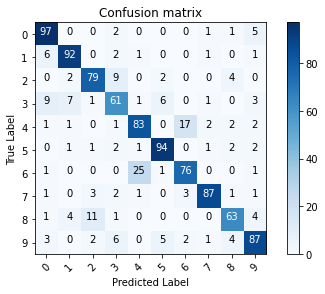

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

target_names=['(0) Keropeng_Apel',
              '(1) Busuk_Hitam_Apel',
              '(2) Busuk_Hitam_Anggur',
              '(3) Esca_Anggur',
              '(4) Hawar_Daun_Anggur',
              '(5) Bercak_Kering_Kentang',
              '(6) Hawar_Daun_Kentang',
              '(7) Bercak_Bakteri_Tomat',
              '(8) Bercak_Septoria_Tomat',
              '(9) Bercak_Coklat_Tomat']
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(NUM_CLASSES))
print(classification_report(Y_true, Y_pred_classes, target_names = target_names))

In [0]:
total_time_spent = time.time()-total_time

In [0]:
#total waktu jalannya program
print('Waktu untuk membuat data latih dan data uji:', make_data_time_spent)
print('Waktu untuk melatih data:', train_time_spent)
print('Total waktu keseluruhan:', total_time_spent)

Waktu untuk membuat data latih dan data uji: 21.90223240852356
Waktu untuk melatih data: 7307.794727563858
Total waktu keseluruhan: 7493.5996425151825
